In [4]:
import xarray as xr
import numpy as np

import datetime
import matplotlib.pyplot as plt
from model.utils import int_to_datetime

import glob

In [5]:
ports = {
    'churchill': (58.875, -94.27),  # (58.7745, -94.1935),
    'inukjuak': (58.4514, -78.1351),
    'quaqtaq': (61.0442, -69.6421),
    # 'sanirajak': (),
}
ds = xr.open_mfdataset(glob.glob('data/hb_era5_glorys_nc/*.nc'))
mask = np.isnan(ds.siconc.isel(time=0))

with open('ports_trajectory_map_churchill.npy', 'rb') as f:
    trajectory_mask = np.load(f)

results_dir = 'ice_results_may7_exp_0'

months = list(range(1, 13))
ds_pred = []
for month in months:
    try:
        ds_pred.append(xr.open_dataset(f'{results_dir}/valpredictions_M{month}_Y2011_Y2015_I10O90.nc', engine='netcdf4'))
    except Exception as e: #FileNotFoundError:
        print(e)
        pass
    
ds_pred = xr.concat(ds_pred, dim='launch_date')
ds_pred = ds_pred.rio.set_crs(4326)
ds_pred['launch_date'] = [int_to_datetime(dt) for dt in ds_pred.launch_date.values]

ds = ds.isel(time=slice(0, -1))
ds_pred = ds_pred.isel(launch_date=slice(0, -1))

FileNotFoundError: [Errno 2] No such file or directory: 'ports_trajectory_map_churchill.npy'

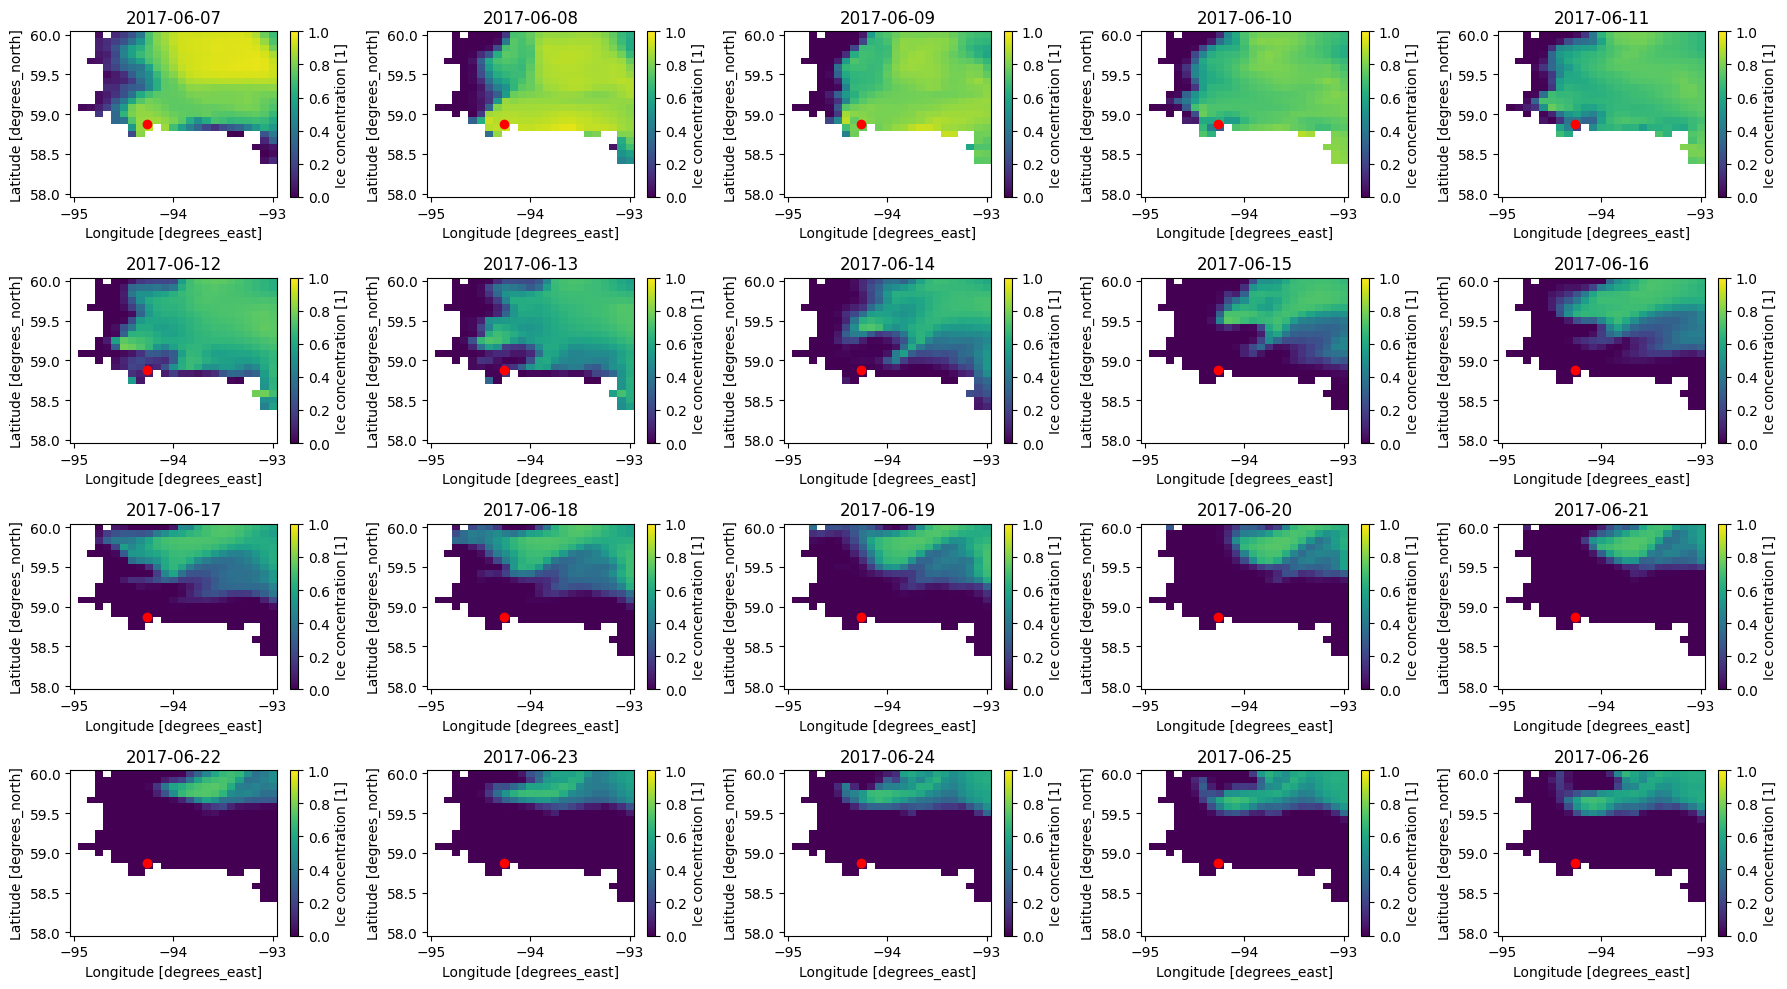

In [398]:
ds_ch = ds.sel(latitude=slice(58, 60), longitude=slice(-95, -93))
mask_ch = mask.sel(latitude=slice(58, 60), longitude=slice(-95, -93))
ds_ch = ds_ch.sel(time=slice(datetime.datetime(2017, 6, 7), datetime.datetime(2017, 6, 7+19)))

fig, axs = plt.subplots(4, 5, figsize=(18, 10))
for i, t in enumerate(ds_ch.time.values):
    ds_ch.sel(time=t).fillna(0).where(~mask_ch).siconc.plot(vmin=0, vmax=1, ax=axs.flatten()[i])
    axs.flatten()[i].scatter(ports['churchill'][1], ports['churchill'][0], c='r')
    axs.flatten()[i].set_title(str(t)[:10])
plt.tight_layout()

In [163]:
def get_breakup_date(ds, port):
    lat = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['latitude'].values)
    lon = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['longitude'].values)

    lat_i, lon_i = np.argwhere(ds.latitude.values==lat)[0][0], np.argwhere(ds.longitude.values==lon)[0][0]

    ds_window = ds.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5)).siconc
    mask_window = mask.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5))
    ds_window = ds_window.fillna(0).where(~mask_window)
    proportion_ice = ((ds_window > 0.15).sum(['latitude', 'longitude']) / np.sum(~mask_window))

    years = np.unique(ds.time.dt.year)
    
    breakup_dates = {}
    for year in years:
        breakup_window = proportion_ice.sel(time=slice(datetime.datetime(year, 5, 15), datetime.datetime(year, 7, 15)))
        breakup_date = breakup_window.time[np.argwhere(breakup_window.values>0.3)[-1]]
        
        breakup_dates[year] = breakup_date.values
    return breakup_dates

def get_freezeup_date(ds, port):
    lat = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['latitude'].values)
    lon = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['longitude'].values)

    lat_i, lon_i = np.argwhere(ds.latitude.values==lat)[0][0], np.argwhere(ds.longitude.values==lon)[0][0]

    ds_window = ds.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5)).siconc
    mask_window = mask.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5))
    ds_window = ds_window.fillna(0).where(~mask_window)
    proportion_ice = ((ds_window > 0.15).sum(['latitude', 'longitude']) / np.sum(~mask_window))
    
    years = np.unique(ds.time.dt.year)
    
    freezeup_dates = {}
    for year in years:
        freezeup_window = proportion_ice.sel(time=slice(datetime.datetime(year, 10, 15), datetime.datetime(year, 12, 15)))
        freezeup_date = freezeup_window.time[np.argwhere(freezeup_window.values>0.3)[0]]
        
        freezeup_dates[year] = freezeup_date.values
    return freezeup_dates


ds_pred_15 = ds_pred.sel(timestep=15).rename({'launch_date': 'time', 'y_hat': 'siconc'})
ds_pred_30 = ds_pred.sel(timestep=30).rename({'launch_date': 'time', 'y_hat': 'siconc'})

# get_breakup_date(ds_pred_15, 'churchill')
# get_freezeup_date(ds_pred_15, 'churchill')

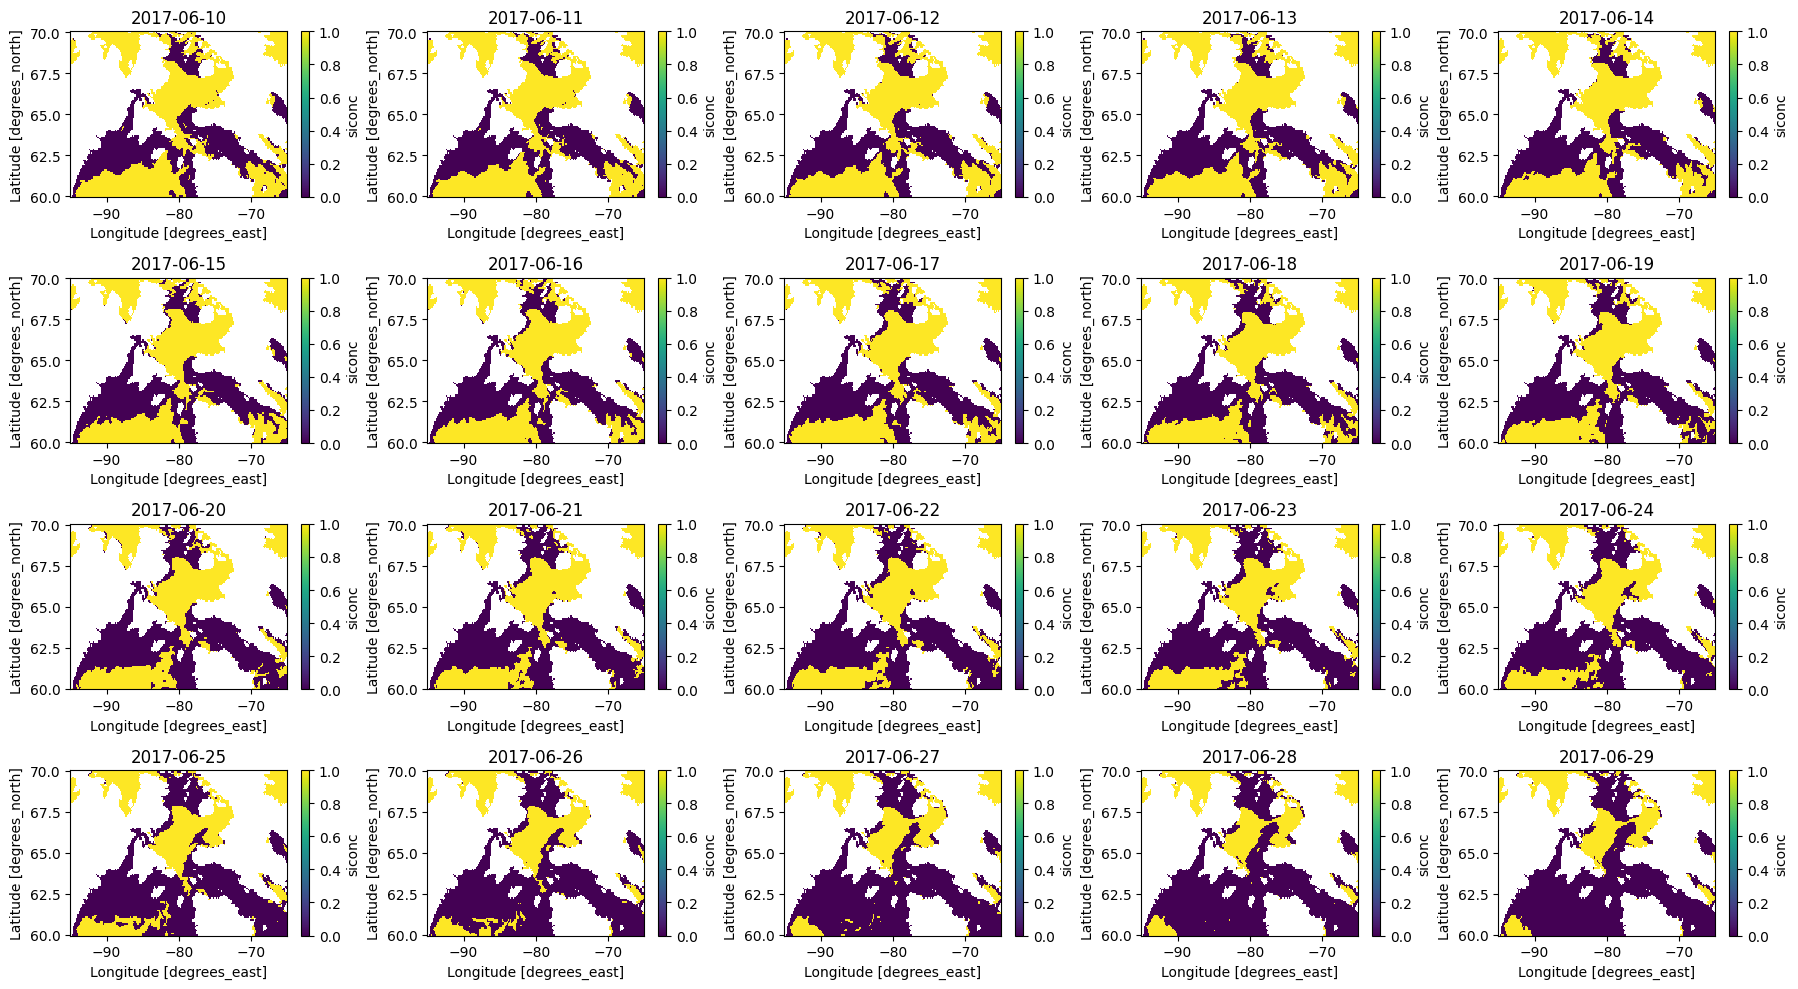

In [164]:
ds_ch = ds.sel(latitude=slice(60, 70), longitude=slice(-95, -65))
mask_ch = mask.sel(latitude=slice(60, 70), longitude=slice(-95, -65))
ds_ch = ds_ch.sel(time=slice(datetime.datetime(2017, 6, 10), datetime.datetime(2017, 6, 10+19)))

fig, axs = plt.subplots(4, 5, figsize=(18, 10))
for i, t in enumerate(ds_ch.time.values):
    (ds_ch.sel(time=t).fillna(0).siconc>0.15).where(~mask_ch).plot(vmin=0, vmax=1, ax=axs.flatten()[i])
    axs.flatten()[i].scatter(ports['churchill'][1], ports['churchill'][0], c='r')
    axs.flatten()[i].set_title(str(t)[:10])
plt.tight_layout()

/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


IndexError: index 0 is out of bounds for axis 0 with size 0

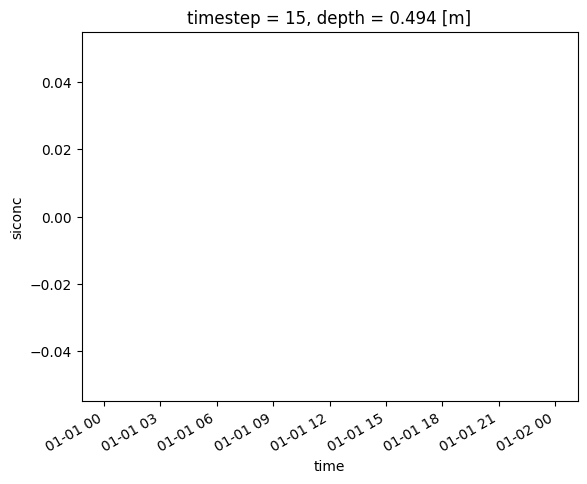

In [128]:
port = 'churchill'
lat = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['latitude'].values)
lon = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['longitude'].values)

lat_i, lon_i = np.argwhere(ds.latitude.values==lat)[0][0], np.argwhere(ds.longitude.values==lon)[0][0]

ds_window = ds.isel(latitude=slice(lat_i-3, lat_i+3), longitude=slice(lon_i-3, lon_i+3)).siconc
mask_window = mask.isel(latitude=slice(lat_i-3, lat_i+3), longitude=slice(lon_i-3, lon_i+3))
ds_window = ds_window.fillna(0).where(~mask_window)
proportion_ice = ((ds_window > 0.15).sum(['latitude', 'longitude']) / np.sum(~mask_window))

for year in range(2017, 2018):
    freezeup_window = proportion_ice.sel(time=slice(datetime.datetime(year, 10, 15), datetime.datetime(year, 12, 15)))
    freezeup_window.plot()
    freezeup_date = freezeup_window.time[np.argwhere(freezeup_window.values>0.3)[0]]
    plt.axvline([freezeup_date], c='r')
    plt.show()

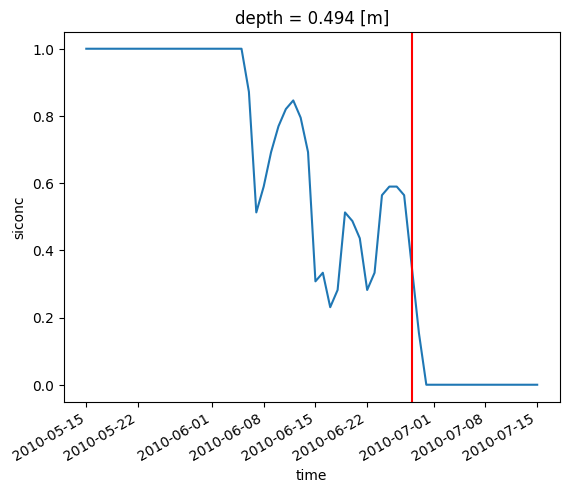

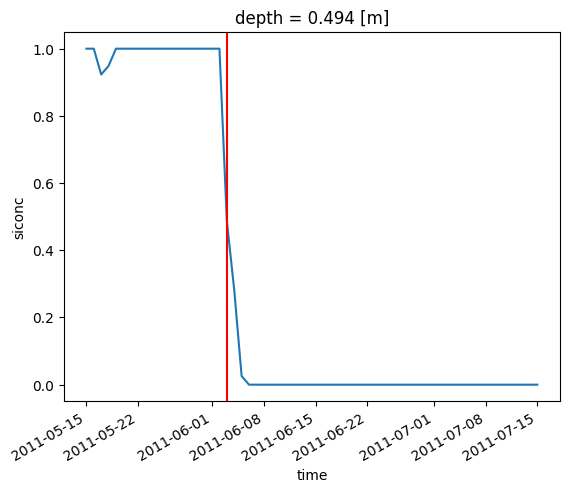

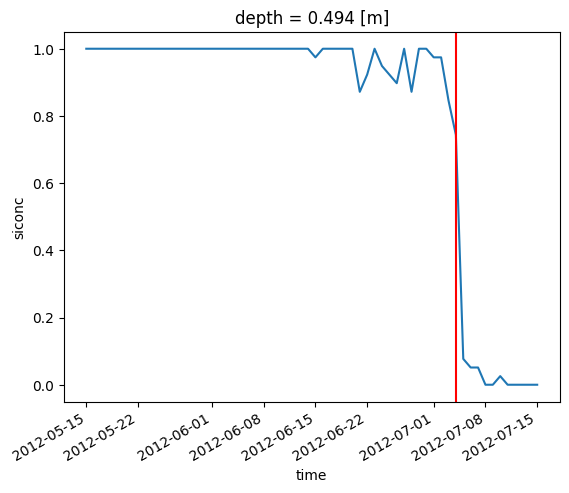

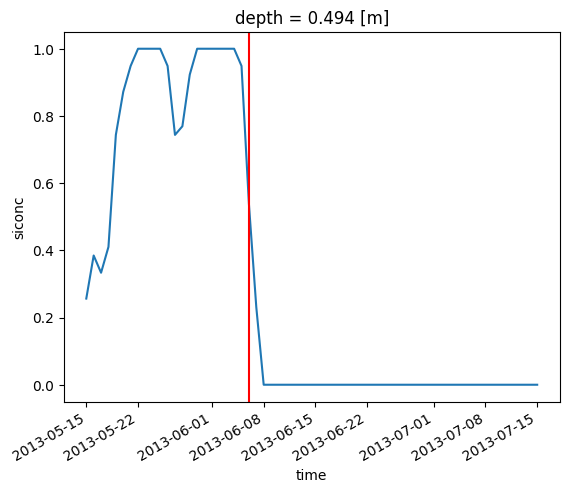

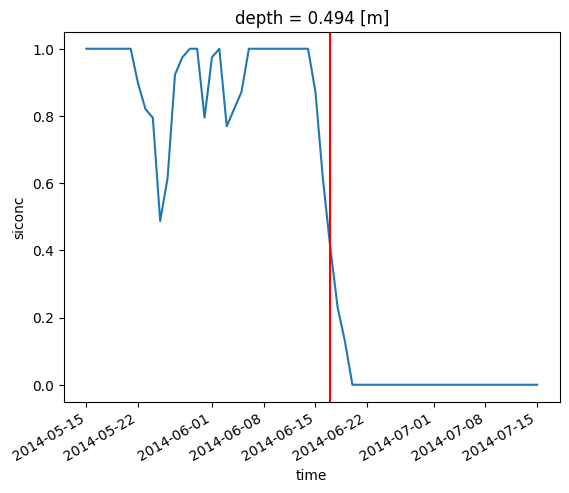

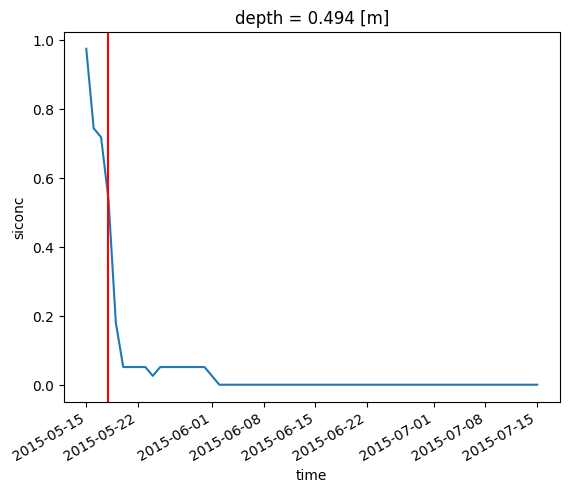

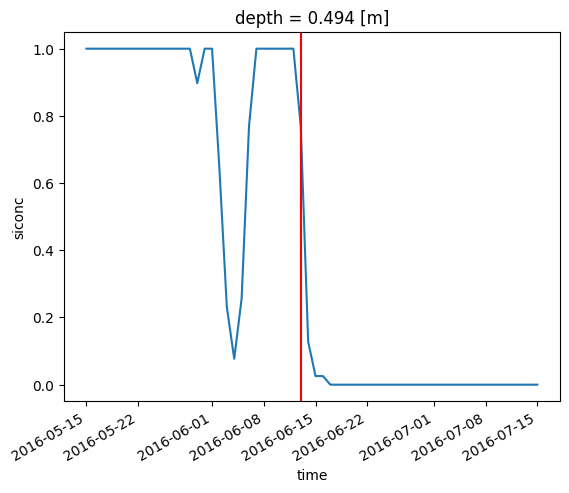

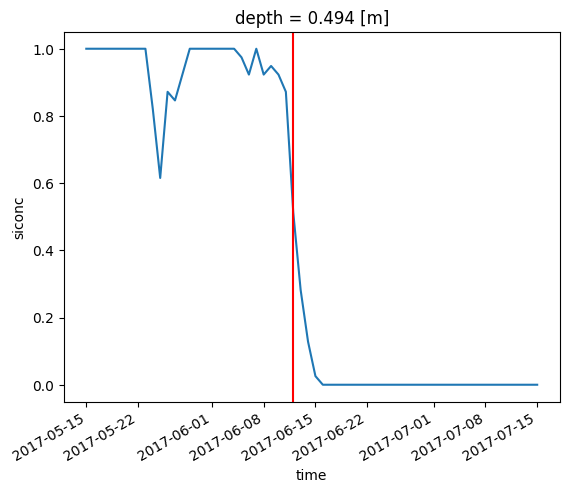

In [62]:
port = 'churchill'
lat = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['latitude'].values)
lon = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['longitude'].values)

lat_i, lon_i = np.argwhere(ds.latitude.values==lat)[0][0], np.argwhere(ds.longitude.values==lon)[0][0]

ds_window = ds.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5)).siconc
mask_window = mask.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5))
ds_window = ds_window.fillna(0).where(~mask_window)
proportion_ice = ((ds_window > 0.15).sum(['latitude', 'longitude']) / np.sum(~mask_window))

for year in range(2010, 2018):
    breakup_window = proportion_ice.sel(time=slice(datetime.datetime(year, 5, 15), datetime.datetime(year, 7, 15)))
    breakup_window.plot()
    breakup_date = breakup_window.time[np.argwhere(breakup_window.values>0.3)[-1]]
    plt.axvline([breakup_date], c='r')
    plt.show()

## Pathways

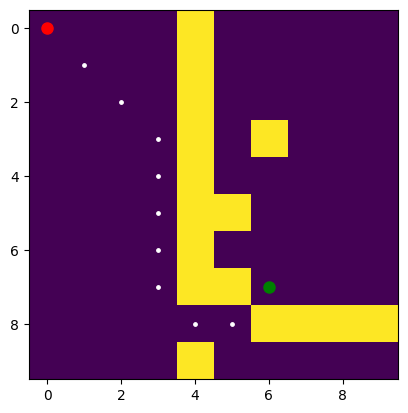

In [404]:
# Credit for this: Nicholas Swift
# as found at https://medium.com/@nicholas.w.swift/easy-a-star-pathfinding-7e6689c7f7b2
from warnings import warn
import heapq

class Node:
    """
    A node class for A* Pathfinding
    """

    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position
    
    def __repr__(self):
        return f"{self.position} - g: {self.g} h: {self.h} f: {self.f}"

    # defining less than for purposes of heap queue
    def __lt__(self, other):
        return self.f < other.f
    
    # defining greater than for purposes of heap queue
    def __gt__(self, other):
        return self.f > other.f

def return_path(current_node):
    path = []
    current = current_node
    while current is not None:
        path.append(current.position)
        current = current.parent
    return np.array(path[::-1])  # Return reversed path


def astar(maze, start, end, allow_diagonal_movement = True):
    """
    Returns a list of tuples as a path from the given start to the given end in the given maze
    :param maze:
    :param start:
    :param end:
    :return:
    """
    
    if maze[start[0]][start[1]]:
        warn('Starting from an invalid pixel.')
        return None
        
    if maze[end[0]][end[1]]:
        warn('Ending from an invalid pixel.')
        return None

    # Create start and end node
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, end)
    end_node.g = end_node.h = end_node.f = 0

    # Initialize both open and closed list
    open_list = []
    closed_list = []

    # Heapify the open_list and Add the start node
    heapq.heapify(open_list) 
    heapq.heappush(open_list, start_node)

    # Adding a stop condition
    outer_iterations = 0
    max_iterations = min((len(maze[0]) * len(maze) // 2), 5000)

    # what squares do we search
    adjacent_squares = ((0, -1), (0, 1), (-1, 0), (1, 0),)
    if allow_diagonal_movement:
        adjacent_squares = ((0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1),)

    # Loop until you find the end
    while len(open_list) > 0:
        outer_iterations += 1
        
        print(outer_iterations, '/', max_iterations, end='\r')

        if outer_iterations > max_iterations:
            # if we hit this point return the path such as it is
            # it will not contain the destination
            warn("giving up on pathfinding too many iterations")
            return None     
        
        # Get the current node
        current_node = heapq.heappop(open_list)
        closed_list.append(current_node)

        # Found the goal
        if current_node == end_node:
            return return_path(current_node)

        # Generate children
        children = []
        
        for new_position in adjacent_squares: # Adjacent squares

            # Get node position
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            # Make sure within range
            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (len(maze[len(maze)-1]) -1) or node_position[1] < 0:
                continue

            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue

            # Create new node
            new_node = Node(current_node, node_position)

            # Append
            children.append(new_node)

        # Loop through children
        for child in children:
            # Child is on the closed list
            if len([closed_child for closed_child in closed_list if closed_child == child]) > 0:
                continue

            # Create the f, g, and h values
            child.g = current_node.g + 1
            child.h = ((child.position[0] - end_node.position[0]) ** 2) + ((child.position[1] - end_node.position[1]) ** 2)
            child.f = child.g + child.h

            # Child is already in the open list
            if len([open_node for open_node in open_list if child.position == open_node.position and child.g > open_node.g]) > 0:
                continue

            # Add the child to the open list
            heapq.heappush(open_list, child)

    warn("Couldn't get a path to destination")
    return None

            
maze = [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]


start = (0, 0)
end = (7, 6)

path = astar(maze, start, end)

plt.imshow(maze)
plt.scatter(*path.T[::-1], c='white', s=6)
plt.scatter(*start[::-1], marker='o', c='r', s=64)
plt.scatter(*end[::-1], marker='o', c='g', s=64)
plt.show()

/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:52: UserWarning: Starting from an invalid pixel.
  warn('Starting from an invalid pixel.')
/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:52: UserWarning: Starting from an invalid pixel.
  warn('Starting from an invalid pixel.')
/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:52: UserWarning: Starting from an invalid pixel.
  warn('Starting from an invalid pixel.')
/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:52: UserWarning: Starting from an invalid pixel.
  warn('Starting from an invalid pixel.')


/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:91: UserWarning: giving up on pathfinding too many iterations
  warn("giving up on pathfinding too many iterations")
/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:142: UserWarning: Couldn't get a path to destination
  warn("Couldn't get a path to destination")
/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:142: UserWarning: Couldn't get a path to destination
  warn("Couldn't get a path to destination")
/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:52: UserWarning: Starting from an invalid pixel.
  warn('Starting from an invalid pixel.')
/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:52: UserWarning: Starting from an invalid pixel.
  warn('Starting from an invalid pixel.')
/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:52: UserWarning: Starting from 

/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:91: UserWarning: giving up on pathfinding too many iterations
  warn("giving up on pathfinding too many iterations")


/var/folders/cm/2c4fl6ps5z956d1yqkc59mqh0000gn/T/ipykernel_95987/2965980930.py:91: UserWarning: giving up on pathfinding too many iterations
  warn("giving up on pathfinding too many iterations")


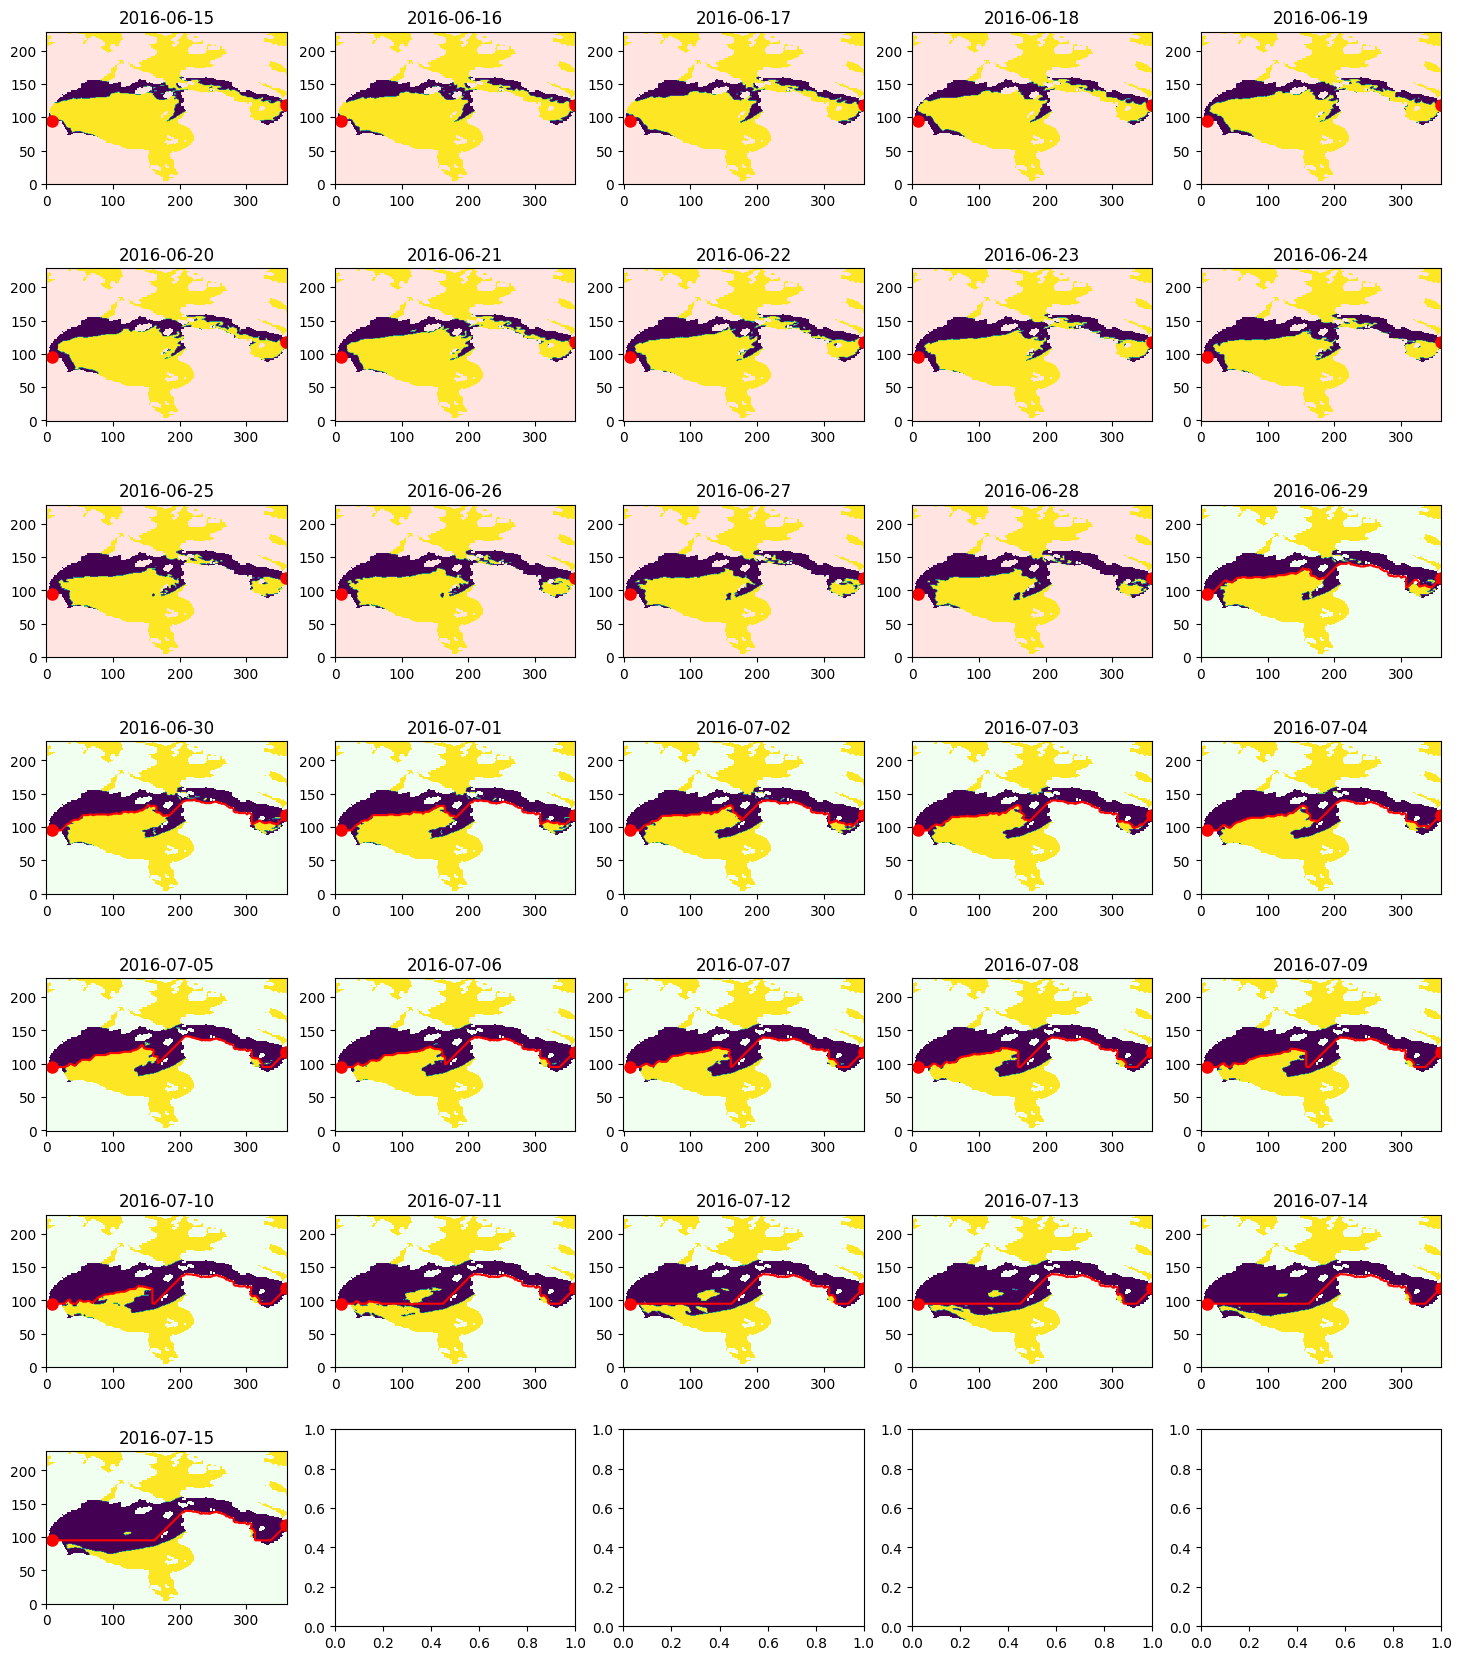

In [443]:
def get_index_from_coords(ds, coords):
    lat = float(ds.sel(latitude=coords[0], longitude=coords[1], method='nearest').coords['latitude'].values)
    lon = float(ds.sel(latitude=coords[0], longitude=coords[1], method='nearest').coords['longitude'].values)
    lat_i, lon_i = np.argwhere(ds.latitude.values==lat)[0][0], np.argwhere(ds.longitude.values==lon)[0][0]
    return (lat_i, lon_i)

def plot_paths(ds, port, start):
    start = get_index_from_coords(ds, start)
    end = get_index_from_coords(ds, ports[port])
    
    fig, axs = plt.subplots(len(ds.time) // 5 + 1, 5, figsize=(18, 3*(len(ds.time) // 5 + 1)))
    
    for i, t in enumerate(ds.time):
        ax = axs.flatten()[i]
        
        maze = ds.sel(time=t).fillna(0).where(~trajectory_mask).fillna(1).siconc.values > 0.15
        
        ax.imshow(np.where(~mask, maze, np.nan))
        ax.scatter(*start[::-1], marker='o', c='r', s=64)
        ax.scatter(*end[::-1], marker='o', c='r', s=64)

        path = astar(maze, start, end)
        
        if path is not None:
            ax.plot(*path.T[::-1], c='r')
            ax.set_title(str(t.values)[:10], color='k')
            ax.patch.set_facecolor('honeydew')
        else:
            ax.set_title(str(t.values)[:10], color='k')
            ax.patch.set_facecolor('mistyrose')
            
        ax.set_ylim(ax.get_ylim()[::-1])
        
    plt.show()

plot_paths(
    ds=ds.sel(time=slice(datetime.datetime(2016, 6, 15), datetime.datetime(2016, 7, 15))),
    port='churchill', 
    start=(60.8, -65)
)
    

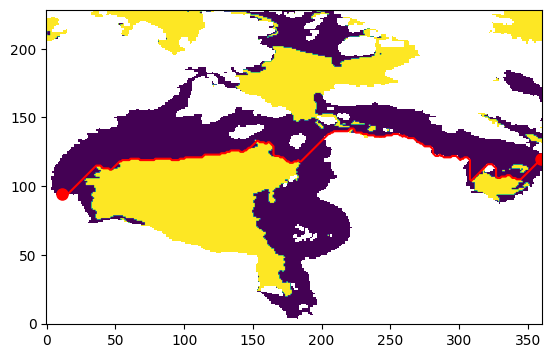

In [369]:
port = 'churchill'
lat = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['latitude'].values)
lon = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['longitude'].values)
lat_i, lon_i = np.argwhere(ds.latitude.values==lat)[0][0], np.argwhere(ds.longitude.values==lon)[0][0]

maze = ds.sel(time=datetime.datetime(2016, 6, 29)).fillna(0).where(~mask).fillna(1).siconc.values > 0.15

start = (120, 360)
end = (lat_i+1, lon_i+1)

plt.imshow(np.where(~mask, maze, np.nan))
plt.scatter(*start[::-1], marker='o', c='r', s=64)
plt.scatter(*end[::-1], marker='o', c='r', s=64)

path = astar(maze, start, end)

plt.plot(*path.T[::-1], c='r')
plt.gca().invert_yaxis()
plt.show()

In [422]:
# from PIL import Image
# import random

# img = Image.new('1', mask.shape)
# pixels = img.load()

# for i in range(img.size[0]):
#     for j in range(img.size[1]):
#         pixels[i, j] = int(mask.values[i][j])

# img.save('/Users/zach/Downloads/mask.bmp')

im = Image.open("/Users/zach/Downloads/mask (1).bmp")
p = np.array(im)[..., 0].astype(bool).T

with open('ports_trajectory_map_churchill.npy', 'wb') as f:
    np.save(f, p)

In [416]:
mask.shape

(229, 361)

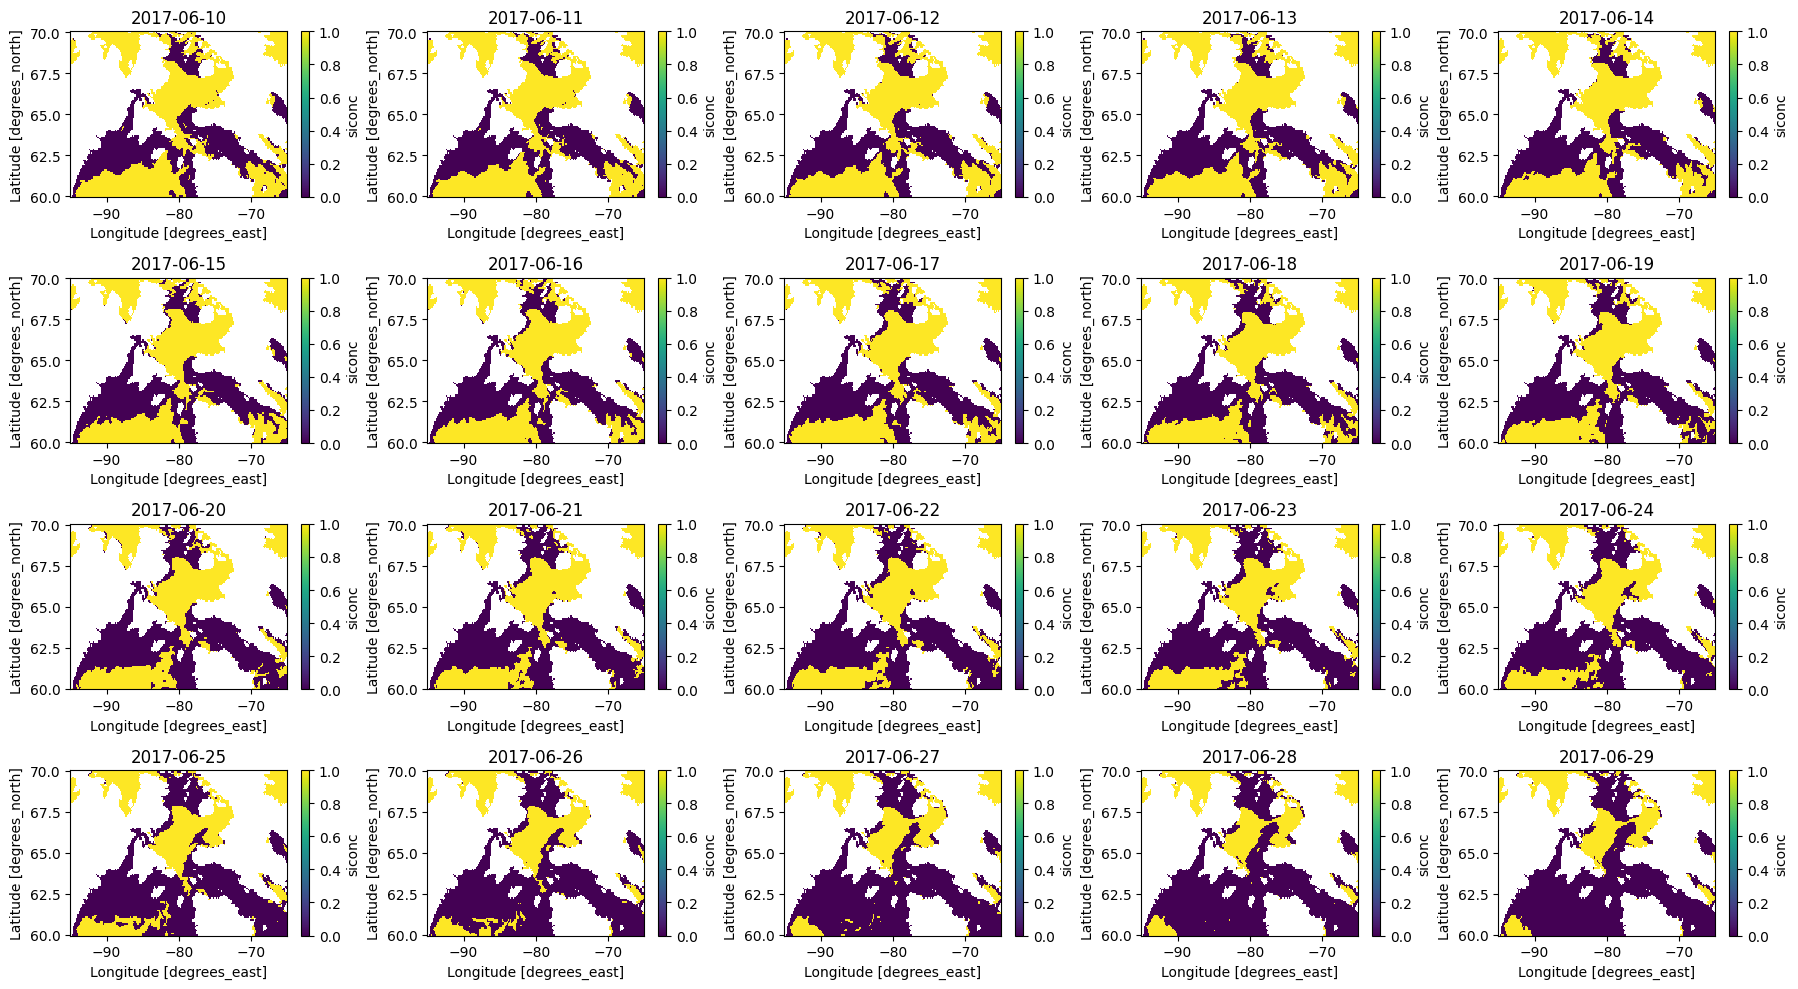

In [165]:
ds_ch = ds.sel(latitude=slice(60, 70), longitude=slice(-95, -65))
mask_ch = mask.sel(latitude=slice(60, 70), longitude=slice(-95, -65))
ds_ch = ds_ch.sel(time=slice(datetime.datetime(2017, 6, 10), datetime.datetime(2017, 6, 10+19)))

fig, axs = plt.subplots(4, 5, figsize=(18, 10))
for i, t in enumerate(ds_ch.time.values):
    (ds_ch.sel(time=t).fillna(0).siconc>0.15).where(~mask_ch).plot(vmin=0, vmax=1, ax=axs.flatten()[i])
    axs.flatten()[i].scatter(ports['churchill'][1], ports['churchill'][0], c='r')
    axs.flatten()[i].set_title(str(t)[:10])
plt.tight_layout()

In [36]:
corridors

<xarray.Dataset>
Dimensions:      (band: 4, latitude: 229, longitude: 361)
Coordinates:
  * band         (band) int64 1 2 3 4
    spatial_ref  int64 0
    x            (longitude) float32 -95.0 -94.92 -94.83 ... -65.17 -65.08 -65.0
    y            (latitude) float32 51.0 51.08 51.17 51.25 ... 69.83 69.92 70.0
  * longitude    (longitude) float32 -95.0 -94.92 -94.83 ... -65.17 -65.08 -65.0
    depth        float32 0.494
  * latitude     (latitude) float32 51.0 51.08 51.17 51.25 ... 69.83 69.92 70.0
Data variables:
    band_data    (band, latitude, longitude) float64 nan nan nan ... nan nan nan

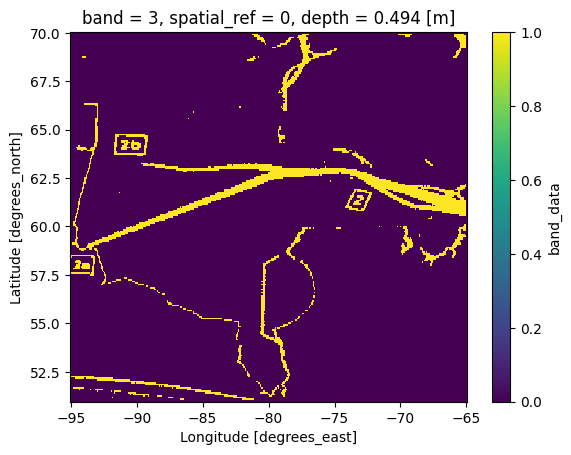

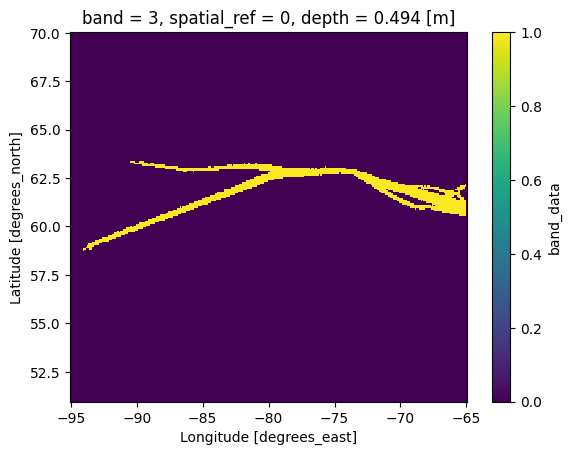

In [66]:
corridors = xr.open_dataset('data/shipping_corridors/shipping_corridors.tif')
corridors = corridors.sel(y=slice(ds.latitude.max(), ds.latitude.min()), x=slice(ds.longitude.min(), ds.longitude.max()))
corridors = corridors.interp(x=ds.longitude, y=ds.latitude)
primary_route = (corridors.isel(band=2).band_data < 175)
primary_route.plot()
plt.show()

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.imsave('data/shipping_corridors/primary_route.png', primary_route.values, cmap=cm.gray)

# manually edited the png

from PIL import Image
primary_route_arr = Image.open('data/shipping_corridors/primary_route_mask.png').convert("L")
primary_route.values = np.array(primary_route_arr).astype(bool)

primary_route.plot()
plt.show()

primary_route.to_netcdf('data/shipping_corridors/primary_route_mask.nc')